# Rebalancing Trader

The goal of the `rebalancing` trader is to find out what is the optimal allocation of funds between the base (crypto)currency and the quote currency.

At any given moment the trader has (on its account) some amount $b$ of a base (crypto)currency (e.g. `BTC`) and some amount $q$ of a quote currency (e.g. `USD`). Let $p$ denote the base (crypto)currency price (e.g. `BTCUSD` price). The total value of this portfolio is then $v = b * p + q$. Let's assume that $v > 0$ and that we would like to keep $\alpha * 100\%$ of the total portfolio value in the base (crypto)currency, i.e. we would like to maintain the following relation: $b * p = \alpha * (b * p + q)$ over time (let's call this $\alpha$-allocation, where $\alpha \in [0; 1]$). The question is, what is the optimal value of $\alpha$ and how to maintain this $\alpha$-allocation over time with as little transaction fees as possible?

Let's start with the second part (maintaining the $\alpha$-allocation over time). It is easy to see that the more precise allocation we want the more often we need to rebalance the portfolio (which means executing more transactions and incurring more transaction fees). Therefore, we need to allow for a certain imprecision in the allocation so that we do not rebalance too often.  Let's introduce another hyper-parameter $\epsilon \in (0; 1)$ such that we allow the base (crypto)currency allocation: $\beta(p) := (b * p) / (b * p + q)$ to be in the range $I = (\alpha * (1 - \epsilon); \alpha * (1 + \epsilon))$. As long as the price $p$ remains relatively stable and $\beta(p)$ remains inside the interval $I$ we do not need to do anything. However, if the price $p$ changes too much, we might need to rebalance the portfolio (i.e. exchange $b$ for $q$) to restore the $\alpha$-allocation.

Before we proceed, let's make some observations about $\beta(p)$:

* Obviously $\beta(p) \in [0; 1]$. Furthermore, $\beta(p) = 0$ iff $b = 0$ and $\beta(p) = 1$ iff $q = 0$. (We assume that $p > 0$ at all times.)
* The first derivate $\beta'(p) = (b * q) / (b * p + q)^2$. Thus if $b > 0$ and $q > 0$ then $\beta(p)$ is an increasing function w.r.t. the price $p$ (which makes intuitive sense, because the higher the price the higher the value of the base (crypto)currency part of the portfolio). If $b = 0$ or $q = 0$ then $\beta(p)$ is a constant function.

Now let's think about how to restore the $\alpha$-allocation. Obviously, if $\beta(p) > \alpha$ we need to sell some amount $a$ of the base (crypto)currency, and if $\beta(p) < \alpha$ we need to buy some amount $a$ of the base (crypto)currency.

In the first case ($\beta(p) > \alpha$) we need to sell $a > 0$ of the base (crypto)currency such that: $[(b - a) * p] / [(b - a) * p + q + a * p] = [(b - a) * p] / [b * p + q] = \alpha$. (Note that for simplicity we ignore transaction fees when estimating $a$.) By solving this equation we get $a = [(1 - \alpha) * (b * p + q) - q] / p$.

In the second case ($\beta(p) < \alpha$) we need to buy $a > 0$ of the base (crypto)currency such that: $[(b + a) * p] / [b * p + q] = \alpha$. By solving this equation we get $a = [q - (1 - \alpha) * (b * p + q)] / p$.

By executing the corresponding market order we restore the desired $\alpha$-allocation.

Note, however, that as long as $\beta(p) \in I$ we do not need to do anything. Moreover, we do not need to wait until $\beta(p)$ reaches one of the borders of the interval $I$. We can do better and set up (static) limit orders that will take care of the rebalancing. (These have usually lower fees than market orders.) Let's assume that both $b > 0$ and $q > 0$ (otherwise $\beta(p)$ would be a constant and we would have to fall back to the market orders.)

If $\alpha * (1 + \epsilon) < 1$ then we might ask at what price $p_+$ will $\beta(p_+)$ reach the upper bound $\alpha * (1 + \epsilon)$ of the interval $I$? By solving the equation $\beta(p_+) = \alpha * (1 + \epsilon)$ we get $p_+ = [\alpha * (1 + \epsilon) * q] / [1 - \alpha * (1 + \epsilon)]$. Now that we know the price $p_+$ we need to figure out what amount $a \le b$ of the base (crypto)currency we need to sell (at the price $p_+$) in order to restore the $\alpha$-allocation. By solving the equation $[(b - a) * p_+] / [b * p_+ + q] = \alpha$ we get $a = b * \epsilon / (1 + \epsilon)$. This fully specifies all parameters of the limit sell order (independent of price $p$).

Similarly, we might ask at what price $p_-$ will $\beta(p_-)$ reach the lower bound $\alpha * (1 - \epsilon)$ of the interval $I$? By solving the equation $\beta(p_-) = \alpha * (1 - \epsilon)$ we get $p_- = [\alpha * (1 - \epsilon) * q] / [1 - \alpha * (1 - \epsilon)]$. Now that we know the price $p_-$ we need to figure out what amount $a > 0$ of the base (crypto)currency we need to buy (at the price $p_-$) in order to restore the $\alpha$-allocation. By solving the equation $[(b + a) * p_-] / [b * p_- + q] = \alpha$ we get $a = b * \epsilon / (1 - \epsilon)$. Again, this fully specifies all parameters of the limit buy order (independent of price $p$).

Now let's pick $\alpha = 0.70$ and $\epsilon = 0.05$ and let's run the `rebalancing` trader over over a 4 year time period: `[2017-01-01 - 2021-01-01)` with 5 minute sampling rate as follows:

```
bazel run :trader -- \
  --input_ohlc_history_delimited_proto_file="/$(pwd)/data/bitstampUSD_5min.dpb" \
  --trader="rebalancing" \
  --output_exchange_log_file="/$(pwd)/data/bitstampUSD_5min_rebalancing_exchange_log.out.csv" \
  --output_trader_log_file="/$(pwd)/data/bitstampUSD_5min_rebalancing_trader_log.csv" \
  --start_date_utc="2017-01-01" \
  --end_date_utc="2021-01-01" \
  --start_base_balance=1.0 \
  --start_quote_balance=0.0
```

Now let's analyze the resulting exchange log: `data/bitstampUSD_5min_rebalancing_exchange_log.out.csv`.

In [1]:
import pandas as pd

exchange_log_frame = pd.read_csv(
    '../data/bitstampUSD_5min_rebalancing_exchange_log.out.csv', names=[
    'timestamp_sec', 'open', 'high', 'low', 'close', 'volume',
    'base_balance', 'quote_balance', 'total_fee',
    'order_type', 'order_side', 'security_amount', 'cash_amount', 'price'])
exchange_log_frame['portfolio_value'] = (
    exchange_log_frame['base_balance'] * exchange_log_frame['close'] +
    exchange_log_frame['quote_balance'])
exchange_log_frame['beta'] = (
    exchange_log_frame['base_balance'] * exchange_log_frame['close'] /
    exchange_log_frame['portfolio_value'])
exchange_log_frame.set_index(
    pd.to_datetime(exchange_log_frame['timestamp_sec'],
                   utc=True, unit='s'), inplace=True)
exchange_log_frame.index.name = None
exchange_log_frame[:5]

,timestamp_sec,open,high,low,close,volume,base_balance,quote_balance,total_fee,order_type,order_side,security_amount,cash_amount,price,portfolio_value,beta
2017-01-01 00:00:00+00:00,1483228800,966.34,966.37,966.16,966.37,15.697,1.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,966.370,1.000000
2017-01-01 00:05:00+00:00,1483229100,966.43,966.58,966.43,966.58,0.439,1.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,966.580,1.000000
2017-01-01 00:05:00+00:00,1483229100,966.43,966.58,966.43,966.58,0.439,0.7,288.47,1.45,MARKET,SELL,0.3,NaN,NaN,965.076,0.701091
2017-01-01 00:10:00+00:00,1483229400,966.57,966.57,964.60,965.55,6.662,0.7,288.47,1.45,NaN,NaN,NaN,NaN,NaN,964.355,0.700867
2017-01-01 00:15:00+00:00,1483229700,965.59,966.57,965.55,965.55,20.773,0.7,288.47,1.45,NaN,NaN,NaN,NaN,NaN,964.355,0.700867


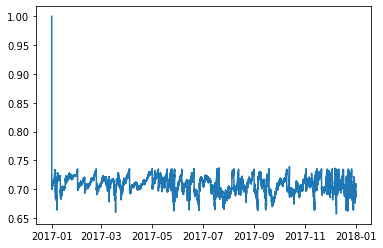

In [2]:
import matplotlib.pyplot as plt

plt.plot(
    exchange_log_frame['2017'].index,
    exchange_log_frame['2017']['beta']);

This is exactly what we would like to see. We start with a full portfolio allocation to the base (crypto)currency immediatelly followed by a single market sell order restoring the $0.70$-allocation. Then we keep the allocation within the range $(0.70 * 0.95; 0.70 * 1.05)$.